### Downloading real images from COCO dataset

In [1]:
import random
import requests
import numpy as np
from tqdm import tqdm
from PIL import Image
from io import BytesIO
from pathlib import Path
from itertools import islice
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from concurrent.futures import ThreadPoolExecutor

In [2]:
# Initialise COCO API for instance annotations. train2017 has 118 000 images, val2017 has 5 000
img_dir = Path.cwd() / "../images"
coco = COCO(img_dir / "annotations_trainval2017" / "annotations" / "instances_val2017.json") # Or "instances_train2017.json"
coco_caps = COCO(img_dir / "annotations_trainval2017" / "annotations" / "captions_val2017.json")
captions_fname = img_dir / "captions.txt"

loading annotations into memory...
Done (t=1.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [3]:
# Get all COCO image IDs
img_ids = coco.getImgIds()
print(len(img_ids))

rand_img_ids = np.random.choice(img_ids, size=5000, replace=False)
captions_list = [None] * len(rand_img_ids)

5000


In [4]:
def download_save(args):
    i, img_id = args

    # Load and save the image
    img = coco.loadImgs(int(img_id))[0]
    resp = requests.get(img['coco_url'])
    fname = img_dir / f"real/{str(i).zfill(4)}.jpg"
    with open(fname, "wb") as f:
        f.write(resp.content)

    # Save an associated caption separately
    ann_ids = coco_caps.getAnnIds(imgIds=img_id)
    anns = coco_caps.loadAnns(ann_ids)
    captions_list[i] = anns[0]["caption"].strip()

    return i

In [5]:
with ThreadPoolExecutor(max_workers=10) as executor:
    list(executor.map(download_save, enumerate(rand_img_ids)))

# Write all captions in order
with open(captions_fname, "w") as f:
    for caption in captions_list:
        f.write(caption + "\n")

### Filtering COCO images and captions

- If catIds or imgIds is empty, the function falls back to self.imgs.keys(), which is all images.
- If you pass a single category, it returns all images that have at least one instance of that category.
- If you pass multiple categories, it returns images that contain all of them simultaneously, which can easily be empty.

In [6]:
# Get COCO categories and associated image IDs
cats = coco.loadCats(coco.getCatIds())
cat_names = [cat['name'] for cat in cats]
print(cat_names)

cat_names = ['bird']
cat_ids = coco.getCatIds(catNms=cat_names)
filt_img_ids = coco.getImgIds(catIds=cat_ids)
print(len(filt_img_ids))

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
125


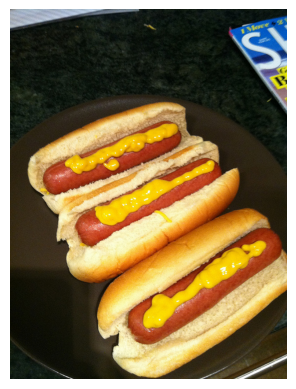

A plate topped with three hot dogs on top of a table.
an image of three hot dogs with mustard
Three hotdgs on a dark plate have been topped with mustard.
Three hotdogs with mustard on a black plate.
a close up of three hot dogs with mustard


In [7]:
rand_img_ids = np.random.choice(img_ids, size=100, replace=False)
img_id = rand_img_ids[0]

# Example of accessing image captions
img = coco_caps.loadImgs(int(img_id))[0]
url = img["coco_url"]

image = Image.open(BytesIO(requests.get(url).content))
plt.imshow(image)
plt.axis("off")
plt.show()

# There are five natural-language descriptions per image
ann_ids = coco_caps.getAnnIds(imgIds=img_id)
anns = coco_caps.loadAnns(ann_ids)
coco_caps.showAnns(anns)

To utilise GPU resources, Kaggle was used to generate images using captions.txt

### FFT analysis

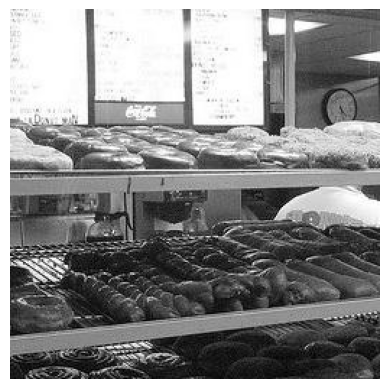

In [8]:
img_dir = Path.cwd() / "../images"
img = Image.open(img_dir / "real_proc" / "0001.jpg").convert("L")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [9]:
def preprocess_imgs(input_dir, output_dir, dims=(256,256), total=None):
    output_dir.mkdir(exist_ok=True)

    img_paths = sorted(input_dir.glob("*.jpg"), key=lambda p: int(p.stem))
    pbar = tqdm(total=total if total is not None else len(img_paths))
    count = 0

    for img_path in img_paths:
        pbar.update(1)
        # We have to handle total this way because we don't know how many images will be skipped
        if total is not None and count >= total:
            break

        with Image.open(img_path) as img:
            img = img.convert("L")
            w, h = img.size

            # Sort out images smaller than desired in any of dimensions
            if w < dims[0] or h < dims[1]:
                continue

            w_start = random.randint(0, w - dims[0])
            h_start = random.randint(0, h - dims[1])

            # left, top, right, bottom
            cropped_img = img.crop((w_start, h_start, w_start + dims[0], h_start + dims[1]))
            cropped_img.save(output_dir / f"{img_path.stem}.jpg")

            count += 1

    pbar.close()

In [10]:
# # With default total=None, process all images in the folders
# preprocess_imgs(img_dir / "real", img_dir / "real_proc")
# preprocess_imgs(img_dir / "gen", img_dir / "gen_proc")

In [11]:
def calc_magnitude_spect(img):
    # 2D FFT of the image array
    fft = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft)  # Move zero frequency to center

    # Magnitude spectrum
    mag = np.abs(fft_shifted)
    mag_log = np.log1p(mag)  # Log scale for visibility

    return mag_log

In [12]:
def calc_radial_prof(arr):
    # Calculate radial distances from the image centre
    h, w = arr.shape
    rows, cols = np.indices((h, w))
    cy = (h - 1) / 2
    cx = (w - 1) / 2
    radial_dists = np.sqrt((rows - cy)**2 + (cols - cx)**2)
    r = radial_dists.astype(int)

    # Calculate sum of pixel values at a certain radius and divide by number of bins at that radius
    sum_bins = np.bincount(r.ravel(), weights=arr.ravel())
    num_bins = np.bincount(r.ravel())
    radial_prof = sum_bins / num_bins

    return radial_prof

In [13]:
def get_rp_arrays(img_dir, total=None):
    rps = []
    img_paths = islice(img_dir.glob("*.jpg"), total)

    for img_path in img_paths:

        img = Image.open(img_path)
        rp = calc_radial_prof(calc_magnitude_spect(img))
        rps.append(rp)

    return rps

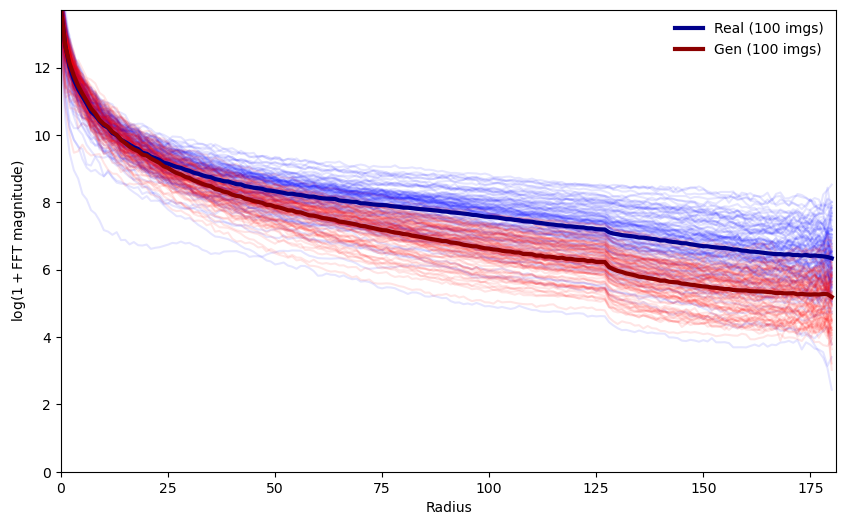

In [14]:
rps_real = get_rp_arrays(img_dir / "real_proc", total=100)
rps_gen = get_rp_arrays(img_dir / "gen_proc", total=100)

plt.figure(figsize=(10,6))

for rp in rps_real:
    plt.plot(rp, color='b', alpha=0.1)

for rp in rps_gen:
    plt.plot(rp, color='r', alpha=0.1)

# Plot array-wise averages of the 2D array
rp_real_avg = np.mean(rps_real, axis=0)
rp_gen_avg = np.mean(rps_gen, axis=0)

plt.plot(rp_real_avg, color='darkblue', linewidth=3, label=f"Real ({len(rps_real)} imgs)")
plt.plot(rp_gen_avg, color='darkred', linewidth=3, label=f"Gen ({len(rps_gen)} imgs)")
plt.ylim(0, max(rp_real_avg.max(), rp_gen_avg.max()))
plt.xlim(0, len(rp_real_avg))
plt.legend(frameon=False)
plt.ylabel(r"$\log(1 + \text{FFT magnitude})$")
plt.xlabel("Radius")
plt.show()

FFT shifts image data from the spatial into the frequency domain. By decomposing the image into its constituent sinusoidal components, we get a magnitude spectrum where the centre represents low-frequencies (slow transitions, shapes) and the periphery represents high-frequencies (fine details, noise, edges). The radial profile is then calculated by averaging the magnitude values at each radius from the centre.

A drop in both curves at radius 128 is a border effect, as beyond that radius, higher radius samples will only be limited to the diagonal corners, and diagonals in natural images typically contain less energy than the axes.

https://www.mdpi.com/2078-2489/15/11/711